Generation des embeddings VIT

In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten,GlobalAveragePooling2D,Input,Lambda
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

IMG_PATH = "images/crop224/image_train/"
batch_size = 15
epochs = 10


df = pd.read_csv("data_tr.csv")
df["prdtypecode"] = df["prdtypecode"].astype(str)


datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, 
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    data_format="channels_last"  
)

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df,test_size=0.2, random_state=42)

train_data = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_PATH,
    x_col="imgname",
    y_col="prdtypecode",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

val_data = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMG_PATH,
    x_col="imgname",
    y_col="prdtypecode",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

test_data = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=IMG_PATH,
    x_col="imgname",
    y_col="prdtypecode",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)


modele_chkpoint = 'google/vit-base-patch16-224' #'google/vit-base-patch16-224-in21k'
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
feature_extractor = ViTFeatureExtractor.from_pretrained(modele_chkpoint,
                    data_format="channels_last",
                    do_resize=True,
                    size=224,
                    do_normalize=True,
                    )
vit_model = TFAutoModelForImageClassification.from_pretrained(modele_chkpoint)


input_image = Input(shape=(224, 224,3))
x = Lambda(lambda image: tf.transpose(image, perm=[0, 3, 1, 2]))(input_image)    
logits = vit_model(x).logits
x = Flatten()(logits)
output = Dense(27, activation='softmax')(x)
    
classification_model = Model(inputs=input_image, outputs=output)


from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-5, epsilon=1e-08, clipnorm=1.0)
loss = CategoricalCrossentropy()

classification_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


early_stopper = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy', mode='auto', patience=2, 
            verbose=1, restore_best_weights=True
        ) 


classification_model.fit(train_data, validation_data=val_data, epochs=epochs,
                         callbacks=[early_stopper])

model_path = "vit_image_classification_model"
feature_extractor_path = "vit_feature_extractor"

vit_model.save_pretrained(model_path)
feature_extractor.save_pretrained(feature_extractor_path)



Found 54345 validated image filenames belonging to 27 classes.
Found 13587 validated image filenames belonging to 27 classes.
Found 16984 validated image filenames belonging to 27 classes.


/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
All PyTorch model weights were used when initializing TFViTForImageClassification.

All the weights of TFViTForImageClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTForImageClassification for predictions without further training.


Epoch 1/10


2023-09-14 13:08:35.518123: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 


1414/3623 [==========>...................] - ETA: 18:09 - loss: 1.8883 - accuracy: 0.4701

KeyboardInterrupt: 

In [2]:
from RktnChallenge.RktnModel import ModelTrainer
trainer = ModelTrainer("data_tr_lemm.csv","")
y_pred = classification_model.predict(test_data)

y = test_df.values.tolist()




2023-09-14 13:00:02.596219: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 


1133/1133 [==============================] - 211s 185ms/step


weighted F1 score: 0.6793396901228761


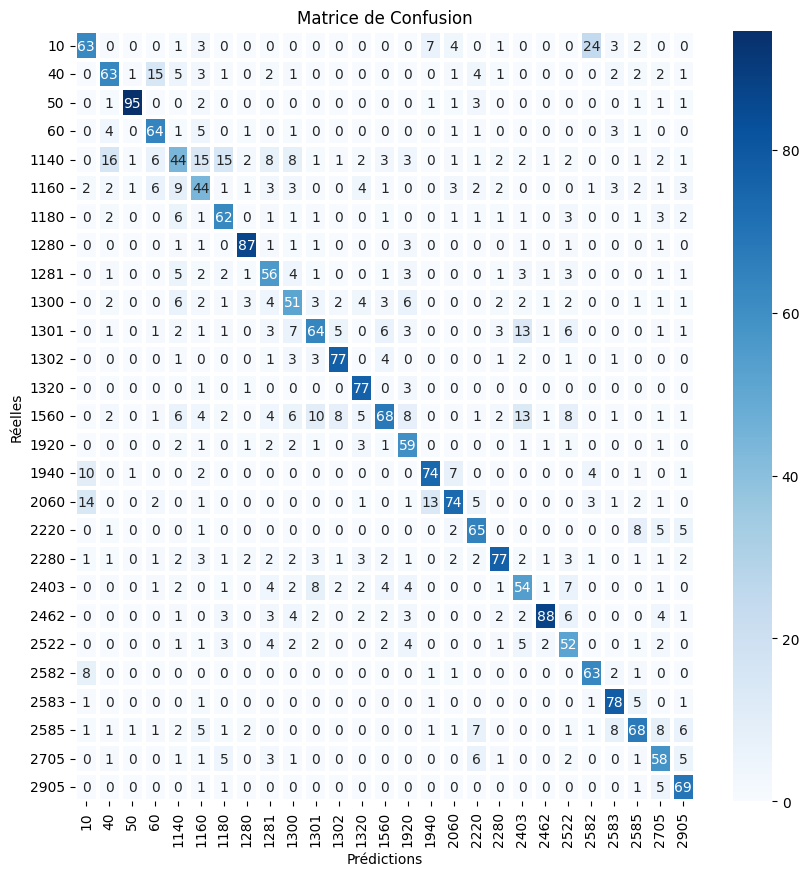

In [3]:
import numpy as np

y_pred_ids = np.argmax(y_pred, axis=1)

y_true = test_df.prdtypecode.values.tolist()

class_indices = train_data.class_indices
class_labels = {v: k for k, v in class_indices.items()}

labels = trainer.encodeLabel("prdtypecode")
y_pred_labels = [class_labels[i] for i in y_pred_ids]
trainer.evaluateTestResults(y_true,y_pred_labels)
#weighted F1 score: 0.6876056966690254


weighted F1 score: 0.6876056966690254


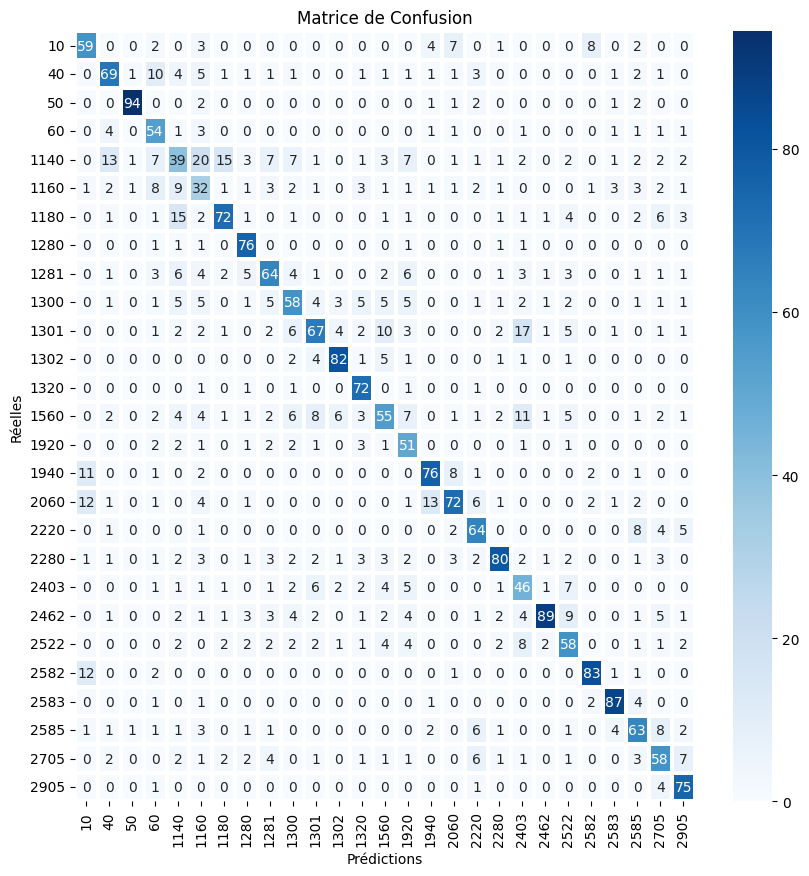

In [4]:
import numpy as np

y_pred_ids = np.argmax(y_pred, axis=1)

y_true = test_df.prdtypecode.values.tolist()

class_indices = train_data.class_indices
class_labels = {v: k for k, v in class_indices.items()}

labels = trainer.encodeLabel("prdtypecode")
y_pred_labels = [class_labels[i] for i in y_pred_ids]
trainer.evaluateTestResults(y_true,y_pred_labels)
#weighted F1 score: 0.6876056966690254


In [42]:


import pandas as pd
import tensorflow as tf
from transformers import ViTFeatureExtractor, TFViTModel
from tqdm import tqdm

model_path = "vit_image_classification_model"
feature_extractor_path = "vit_feature_extractor"

IMG_PATH = "images/crop224/image_train/"


df = pd.read_csv("embeddings_final.csv")
df["prdtypecode"] = df["prdtypecode"].astype(str)


feature_extractor = ViTFeatureExtractor.from_pretrained(feature_extractor_path)
vit_model = TFViTModel.from_pretrained(model_path)

embeddings = []
input_image = Input(shape=(224, 224,3))
x = Lambda(lambda image: tf.transpose(image, perm=[0, 3, 1, 2]))(input_image)    
x = vit_model(x)

embedding_model = Model(inputs=input_image, outputs=x)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255, 
    data_format="channels_last"  
)


train_data = datagen.flow_from_dataframe(
    dataframe=df,
    directory=IMG_PATH,
    x_col="imgname",
    y_col="prdtypecode",
    target_size=(224, 224),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)
   
total_batches = len(train_data) 
i=0
for batch_images, _ in tqdm(train_data, total=len(train_data), desc="Calculating Embeddings"):
    # Calcul des embeddings pour le batch
    result = embedding_model(batch_images)
    pooler_output = result.pooler_output

    embeddings.append(pooler_output)
    if len(embeddings) >= total_batches:
        break 

embeddings = tf.concat(embeddings, axis=0)



df["embedding_vit"] = [list(row) for row in  embeddings.numpy()]

# Sauvegarde le dataframe avec les embeddings
df.to_csv("embeddings_final.csv", index=False)



/home/pec/miniconda3/envs/tfGPU/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some layers from the model checkpoint at vit_image_classification_model were not used when initializing TFViTModel: ['classifier']
- This IS expected if you are initializing TFViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTModel were not initialized from the model checkpoint at vit_image_classification_model and are newly initialized: ['

Found 84916 validated image filenames belonging to 27 classes.


Calculating Embeddings: 100%|█████████▉| 5661/5662 [14:28<00:00,  6.52it/s]


<tf.Tensor: shape=(84916, 768), dtype=float32, numpy=
array([[-0.62579757, -0.3949617 , -0.13472985, ..., -0.00211693,
         0.211566  ,  0.7320239 ],
       [-0.18619248,  0.20758356,  0.0252012 , ...,  0.48921058,
         0.3405125 , -0.35664526],
       [ 0.07957726, -0.13591173,  0.56076324, ..., -0.02062511,
        -0.6805522 , -0.3425021 ],
       ...,
       [-0.3045876 ,  0.3732804 , -0.03553608, ..., -0.29567987,
        -0.3751536 , -0.40836257],
       [-0.5916605 , -0.51324135,  0.250023  , ..., -0.5806292 ,
        -0.16203934,  0.36567247],
       [-0.18084805, -0.06412756,  0.09729077, ..., -0.57916766,
        -0.7315396 ,  0.06904606]], dtype=float32)>

In [66]:
a =embeddings.numpy()
display(a)
df["embedding_vit"] = [list(row) for row in  a]

# Sauvegarder le dataframe mis à jour avec les embeddings
df.to_csv("embeddings_final.csv", index=False)

array([[-0.62579757, -0.3949617 , -0.13472985, ..., -0.00211693,
         0.211566  ,  0.7320239 ],
       [-0.18619248,  0.20758356,  0.0252012 , ...,  0.48921058,
         0.3405125 , -0.35664526],
       [ 0.07957726, -0.13591173,  0.56076324, ..., -0.02062511,
        -0.6805522 , -0.3425021 ],
       ...,
       [-0.3045876 ,  0.3732804 , -0.03553608, ..., -0.29567987,
        -0.3751536 , -0.40836257],
       [-0.5916605 , -0.51324135,  0.250023  , ..., -0.5806292 ,
        -0.16203934,  0.36567247],
       [-0.18084805, -0.06412756,  0.09729077, ..., -0.57916766,
        -0.7315396 ,  0.06904606]], dtype=float32)